In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_enumerator import get_aoi_dataframe,  distill_all_pairs, enumerate_ifgs
import concurrent
from s1_enumerator import duplicate_gunw_found
from tqdm import tqdm

from shapely.geometry import Point
import datetime
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

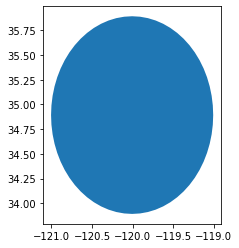

In [3]:
# Over Los Padres National Forest, CA
point = Point(-120.0048, 34.8923)
aoi = point.buffer(1)
df_aoi = get_aoi_dataframe(aoi)
df_aoi.plot()

# Standard Product Enumeration

Gets all tiles that cover AOI and then find suitable sets to generate interferograms.


## Annual Interferogram

- `min_days_backward` refers to the fact all pairs will have at least a certain number of days between pairs. Secondary sets are selected as the latest dates that still have this space. 
- `num_neighbors_ref/_sec` is the number of dates that can be used for interferograms within the `temporal_window_days`.

In [4]:
num_neighbors_ref = 3
num_neighbors_sec = 2
ifg_pairs_tiles = enumerate_ifgs(aoi,
                                 min_reference_date=datetime.datetime(2021, 7, 9), 
                                 enumeration_type='tile',
                                 min_days_backward = 364, 
                                 num_neighbors_ref=num_neighbors_ref,
                                 num_neighbors_sec=num_neighbors_sec,
                                 temporal_window_days=60,
                                 min_ref_tile_overlap_perc=.2,
                                 min_tile_aoi_overlap_km2=1e3,
                                 minimum_path_intersection_km2=1e3, 
                                 minimum_ifg_area_km2=3e4,
                                 entire_s1_catalog=False
                                 )

In [5]:
N = len(ifg_pairs_tiles)
print('total GUNWs (N): ', N)

total GUNWs (N):  51


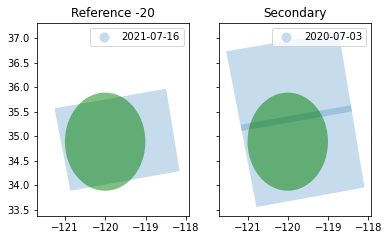

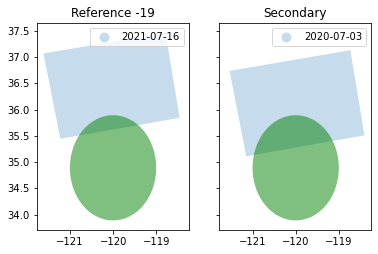

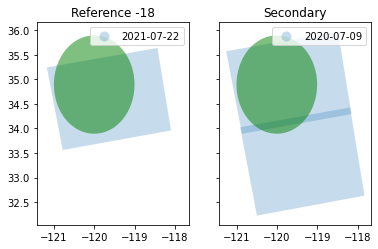

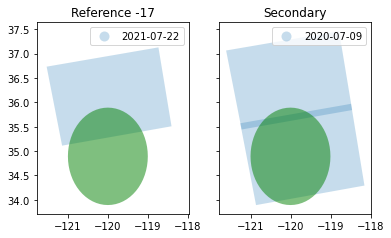

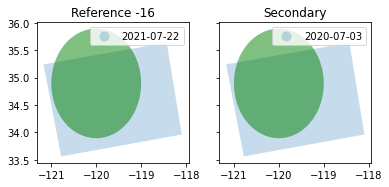

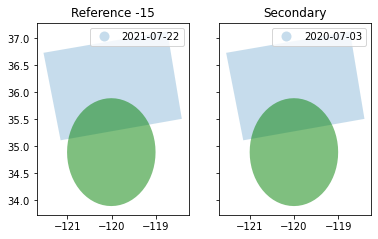

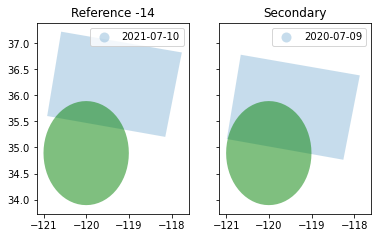

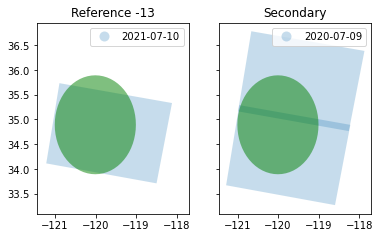

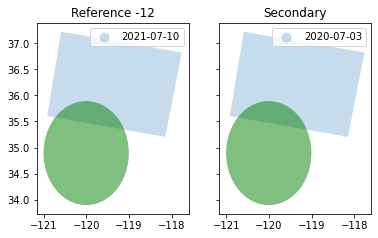

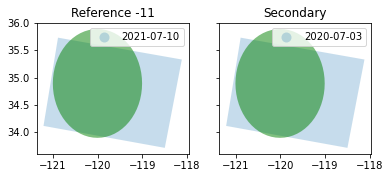

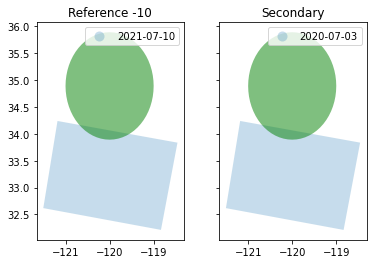

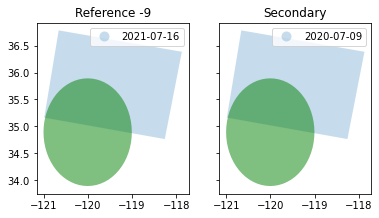

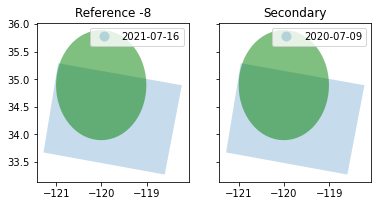

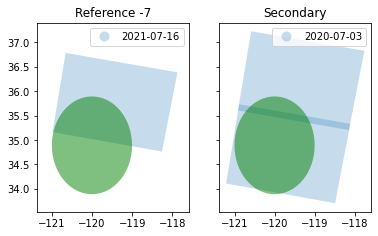

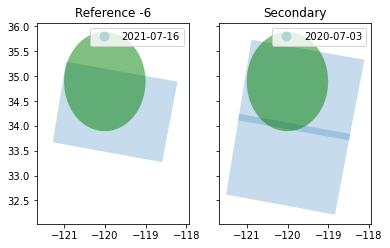

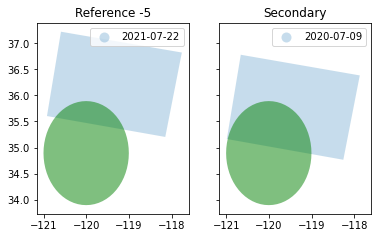

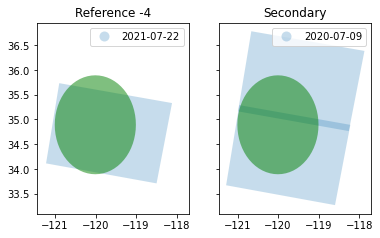

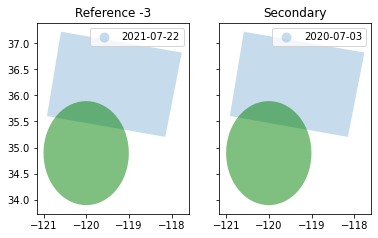

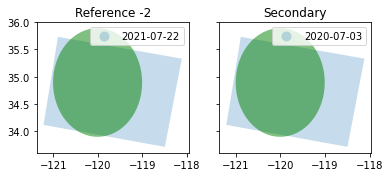

In [6]:
M = min(N, 20)

for J in range(-M, -1, 1):
    pair = ifg_pairs_tiles[J]

    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

    df_ref_plot = pair['reference']
    df_sec_plot = pair['secondary']

    df_ref_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[0], alpha=.25)
    df_aoi.plot(ax=axs[0], alpha=.5, color='green')
    axs[0].set_title('Reference')

    df_sec_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[1], alpha=.25)
    df_aoi.plot(ax=axs[1], alpha=.5, color='green')
    
    axs[0].set_title(f'Reference {J}')
    axs[1].set_title('Secondary')

# Format for API Calls

In [7]:
df_pairs = distill_all_pairs(ifg_pairs_tiles)

Save the file

In [8]:
df_tile_test = df_pairs.sort_values(by=['path_number', 'reference_date']).reset_index(drop=True)
df_tile_test.drop(columns=['reference', 'secondary']).to_file('enum_tile.geojson')

<AxesSubplot:>

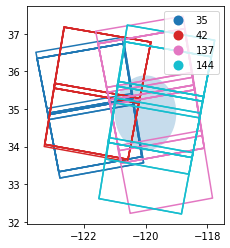

In [9]:
df_pairs_plot = df_pairs.copy()
df_pairs_plot.geometry = df_pairs.geometry.exterior

fig, ax = plt.subplots()
df_aoi.plot(alpha=.25, ax=ax)
df_pairs_plot.plot(column='path_number', categorical=True, legend=True, ax=ax)

In [10]:
records = df_pairs.to_dict('records')
records[:15]

[{'reference': ['S1B_IW_SLC__1SDV_20210709T020610_20210709T020638_027711_034E98_7ACE'],
  'secondary': ['S1A_IW_SLC__1SDV_20200708T020649_20200708T020717_033357_03DD5D_A488'],
  'reference_date': '2021-07-09',
  'secondary_date': '2020-07-08',
  'path_number': 35,
  'geometry': <shapely.geometry.polygon.Polygon at 0x1c62705e0>},
 {'reference': ['S1B_IW_SLC__1SDV_20210709T020636_20210709T020703_027711_034E98_D0BF'],
  'secondary': ['S1A_IW_SLC__1SDV_20200708T020714_20200708T020741_033357_03DD5D_B5A9'],
  'reference_date': '2021-07-09',
  'secondary_date': '2020-07-08',
  'path_number': 35,
  'geometry': <shapely.geometry.polygon.Polygon at 0x1c5b1d0a0>},
 {'reference': ['S1B_IW_SLC__1SDV_20210709T020610_20210709T020638_027711_034E98_7ACE'],
  'secondary': ['S1B_IW_SLC__1SDV_20200702T020604_20200702T020631_022286_02A4BF_C356'],
  'reference_date': '2021-07-09',
  'secondary_date': '2020-07-02',
  'path_number': 35,
  'geometry': <shapely.geometry.polygon.Polygon at 0x1c5f54d90>},
 {'refe

# ASF Lookup

In [11]:
K = 0
entry = records[K]
entry

{'reference': ['S1B_IW_SLC__1SDV_20210709T020610_20210709T020638_027711_034E98_7ACE'],
 'secondary': ['S1A_IW_SLC__1SDV_20200708T020649_20200708T020717_033357_03DD5D_A488'],
 'reference_date': '2021-07-09',
 'secondary_date': '2020-07-08',
 'path_number': 35,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1c62705e0>}

In [12]:
duplicate_gunw_found(entry)

''

In [13]:
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    results = list(tqdm(executor.map(duplicate_gunw_found, records), total=len(records)))

100%|█████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.55it/s]


In [14]:
results

['',
 'S1-GUNW-A-R-035-tops-20210709_20200708-020649-36703N_34825N-PP-3b43-v2_0_4',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'S1-GUNW-D-R-042-tops-20210715_20200708-140841-37129N_35153N-PP-3908-v2_0_4',
 'S1-GUNW-D-R-042-tops-20210715_20200708-140906-35636N_33658N-PP-5247-v2_0_4',
 '',
 '',
 '',
 '',
 '',
 '',
 'S1-GUNW-A-R-137-tops-20210710_20200709-015859-35598N_33556N-PP-54ab-v2_0_4',
 'S1-GUNW-A-R-137-tops-20210710_20200709-015924-37090N_35217N-PP-5589-v2_0_4',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'S1-GUNW-D-R-144-tops-20210710_20200703-140026-37236N_35259N-PP-65c0-v2_0_4',
 'S1-GUNW-D-R-144-tops-20210710_20200703-140051-35745N_33766N-PP-12c6-v2_0_4',
 'S1-GUNW-D-R-144-tops-20210710_20200703-140115-34252N_32270N-PP-1cac-v2_0_4',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']